## Data Loading and Initial Exploration
We'll start by loading the data files provided and taking a quick look at the first few rows of each file. This will help us understand the structure of the data and identify the key columns that we'll be working with.

In [ ]:
import pandas as pd

# Load the data files
file0 = pd.read_csv('file0.csv')
file1 = pd.read_csv('file1.csv')
file2 = pd.read_csv('file2.csv')

# Display the first few rows of each file
file0.head(), file1.head(), file2.head()

(   LoanNr_ChkDgt                           Name          City State    Zip  \
 0     1000014003                 ABC HOBBYCRAFT    EVANSVILLE    IN  47711   
 1     1000024006    LANDMARK BAR & GRILLE (THE)     NEW PARIS    IN  46526   
 2     1000034009          WHITLOCK DDS, TODD M.   BLOOMINGTON    IN  47401   
 3     1000044001  BIG BUCKS PAWN & JEWELRY, LLC  BROKEN ARROW    OK  74012   
 4     1000054004    ANASTASIA CONFECTIONS, INC.       ORLANDO    FL  32801   
 
                             Bank BankState   NAICS ApprovalDate  ApprovalFY  \
 0               FIFTH THIRD BANK        OH  451120    28-Feb-97        1997   
 1                1ST SOURCE BANK        IN  722410    28-Feb-97        1997   
 2        GRANT COUNTY STATE BANK        IN  621210    28-Feb-97        1997   
 3  1ST NATL BK & TR CO OF BROKEN        OK       0    28-Feb-97        1997   
 4        FLORIDA BUS. DEVEL CORP        FL       0    28-Feb-97        1997   
 
    Term  NoEmp  NewExist  CreateJob  Reta

## Data Preprocessing
In this section, we'll combine the three files into a single dataset and perform some basic preprocessing steps. This includes handling missing values, converting data types, and understanding the distribution of key variables. These steps are essential to ensure that the data is clean and ready for analysis.

In [ ]:
# Combine the three files into a single DataFrame
data = pd.concat([file0, file1, file2], ignore_index=True)

# Check the shape of the combined data
data.shape

(899164, 27)

In [ ]:
# Check the data types of each column
data.dtypes

In [ ]:
# Check for missing values in each column
missing_values = data.isnull().sum()
missing_values[missing_values > 0]

In [ ]:
# Fill missing values for categorical columns with a placeholder
data['Name'].fillna('Unknown', inplace=True)
data['City'].fillna('Unknown', inplace=True)
data['State'].fillna('Unknown', inplace=True)
data['Bank'].fillna('Unknown', inplace=True)
data['BankState'].fillna('Unknown', inplace=True)
data['RevLineCr'].fillna('Unknown', inplace=True)
data['LowDoc'].fillna('Unknown', inplace=True)

# Fill missing values for numerical columns with appropriate values
data['NewExist'].fillna(0, inplace=True)

# Convert date columns to datetime objects
data['ApprovalDate'] = pd.to_datetime(data['ApprovalDate'])
data['ChgOffDate'] = pd.to_datetime(data['ChgOffDate'])
data['DisbursementDate'] = pd.to_datetime(data['DisbursementDate'])

# Check if missing values are handled
data.isnull().sum()[data.isnull().sum() > 0]

In [ ]:
# Fill missing DisbursementDate with a placeholder date
data['DisbursementDate'].fillna('1970-01-01', inplace=True)
data['DisbursementDate'] = pd.to_datetime(data['DisbursementDate'])

# Fill missing MIS_Status with a placeholder status
data['MIS_Status'].fillna('Unknown', inplace=True)

# Check if all missing values are handled
data.isnull().sum()[data.isnull().sum() > 0]

## Feature Engineering and Data Exploration
In this section, we'll create new features that may be relevant to our analysis and explore the data through visualizations. We'll analyze how small business loans are approved based on various factors and identify trends and anomalies. This will help us understand the story behind the data and guide our modeling process.

In [ ]:
# Extract the first two digits of the NAICS code to represent the industry sector
data['Industry_Sector'] = data['NAICS'].apply(lambda x: str(x)[:2])

# Extract the month from the ApprovalDate to analyze trends over time
data['Approval_Month'] = data['ApprovalDate'].dt.month

# Check the first few rows to see the new features
data[['Industry_Sector', 'Approval_Month']].head()

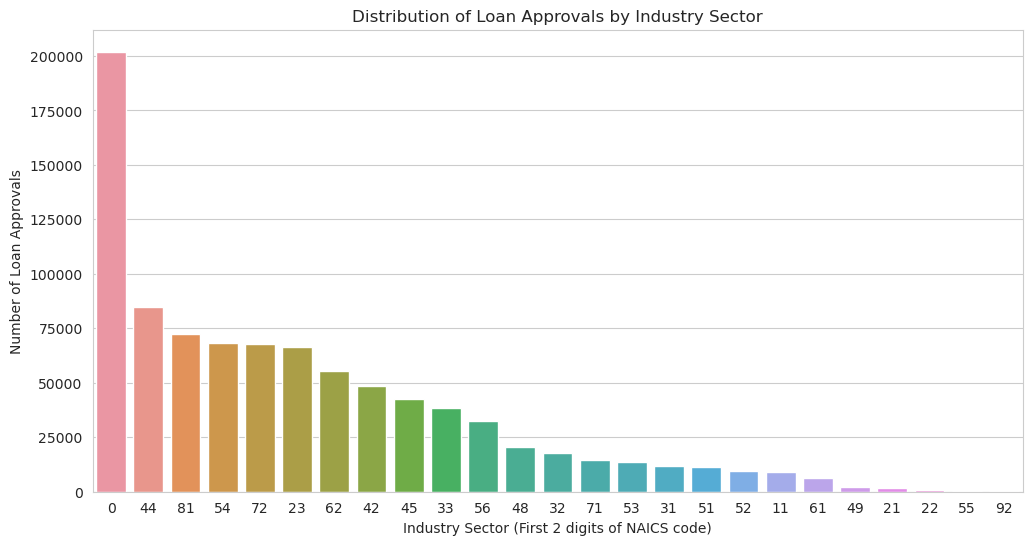

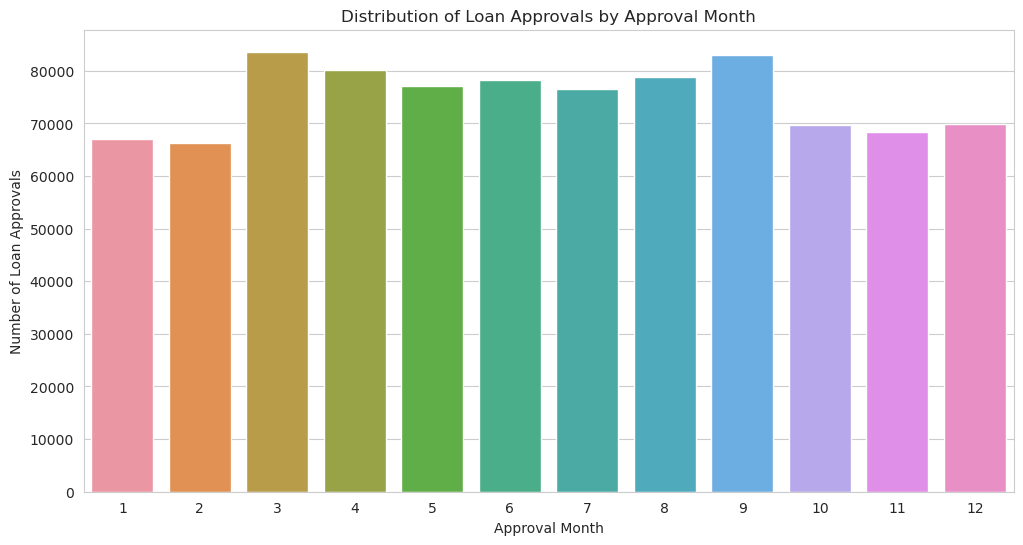

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set_style('whitegrid')

# Plot the distribution of loan approvals by industry sector
plt.figure(figsize=(12, 6))
sns.countplot(x='Industry_Sector', data=data, order=data['Industry_Sector'].value_counts().index)
plt.title('Distribution of Loan Approvals by Industry Sector')
plt.xlabel('Industry Sector (First 2 digits of NAICS code)')
plt.ylabel('Number of Loan Approvals')
plt.show()

# Plot the distribution of loan approvals by approval month
plt.figure(figsize=(12, 6))
sns.countplot(x='Approval_Month', data=data)
plt.title('Distribution of Loan Approvals by Approval Month')
plt.xlabel('Approval Month')
plt.ylabel('Number of Loan Approvals')
plt.show()

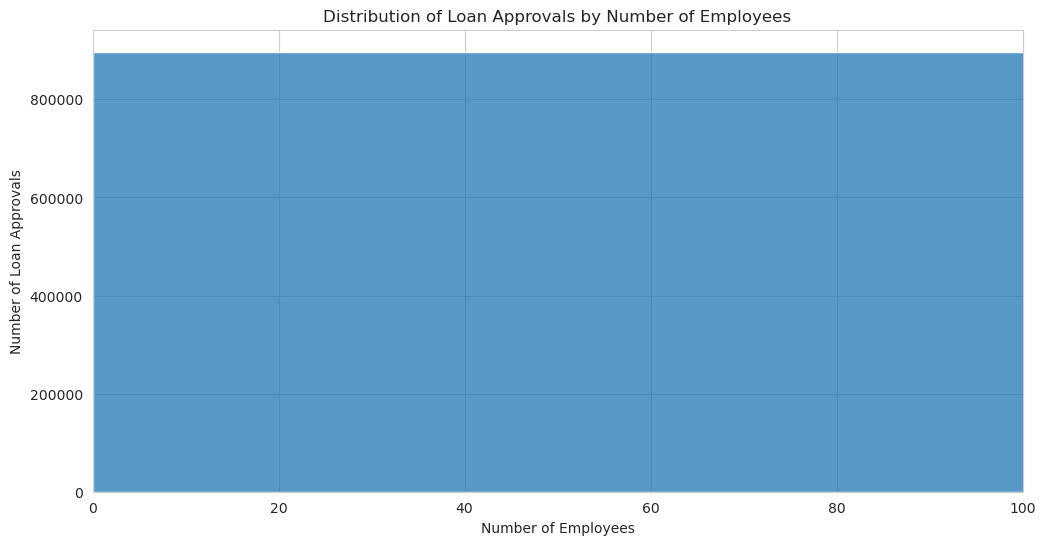

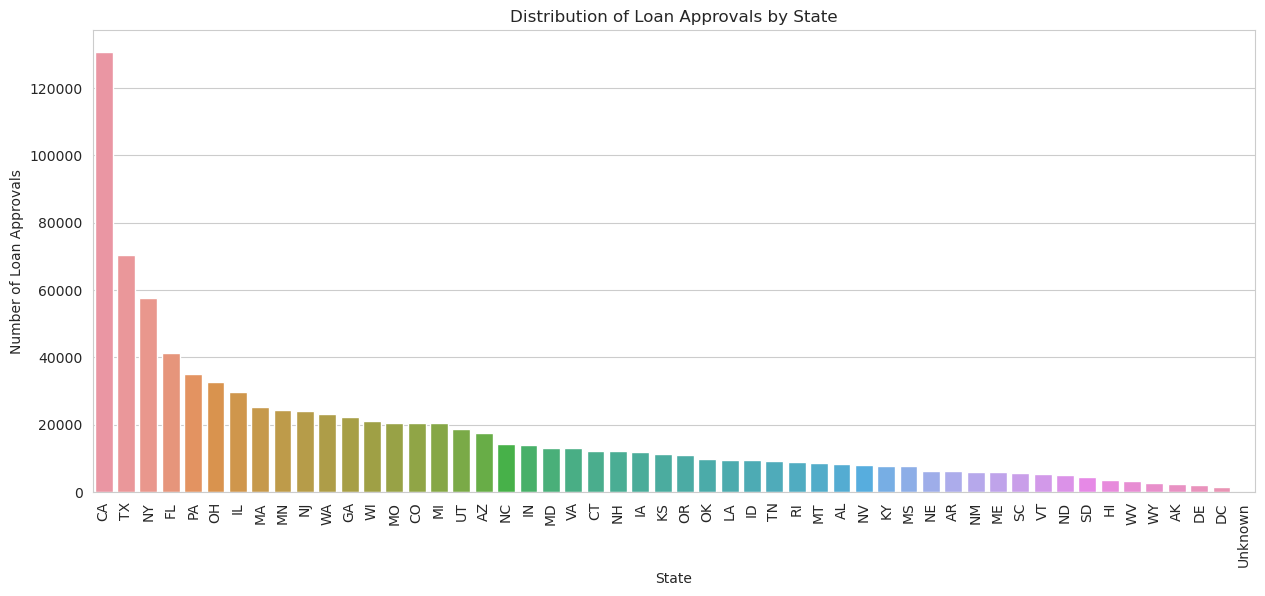

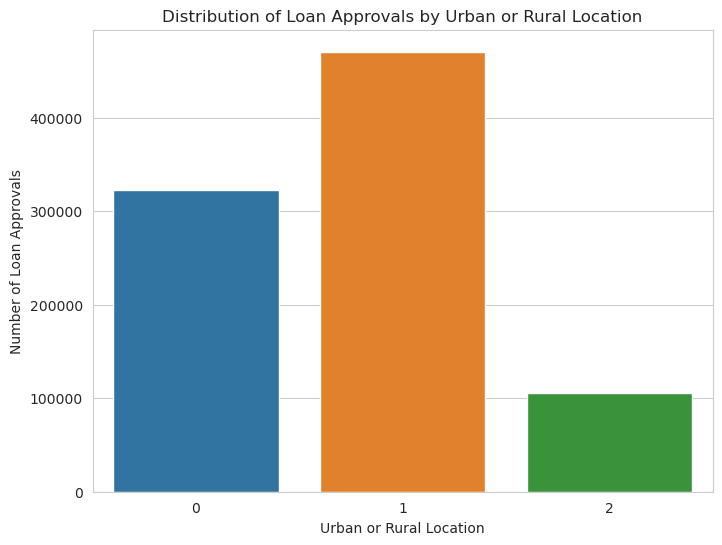

In [ ]:
# Plot the distribution of loan approvals by the number of employees (NoEmp)
plt.figure(figsize=(12, 6))
sns.histplot(data['NoEmp'], bins=50, kde=False)
plt.title('Distribution of Loan Approvals by Number of Employees')
plt.xlabel('Number of Employees')
plt.ylabel('Number of Loan Approvals')
plt.xlim(0, 100) # Limiting the x-axis to focus on the common range
plt.show()

# Plot the distribution of loan approvals by state
plt.figure(figsize=(15, 6))
sns.countplot(x='State', data=data, order=data['State'].value_counts().index)
plt.title('Distribution of Loan Approvals by State')
plt.xlabel('State')
plt.ylabel('Number of Loan Approvals')
plt.xticks(rotation=90) # Rotating the x-axis labels for better visibility
plt.show()

# Plot the distribution of loan approvals by urban or rural location (UrbanRural)
plt.figure(figsize=(8, 6))
sns.countplot(x='UrbanRural', data=data)
plt.title('Distribution of Loan Approvals by Urban or Rural Location')
plt.xlabel('Urban or Rural Location')
plt.ylabel('Number of Loan Approvals')
plt.show()

In [ ]:
from datetime import datetime

# Converting 'SBA_Appv' and 'GrAppv' to numerical values
data['SBA_Appv'] = data['SBA_Appv'].replace('[\$,]', '', regex=True).astype(float)
data['GrAppv'] = data['GrAppv'].replace('[\$,]', '', regex=True).astype(float)

# Creating a feature to categorize businesses as new or established
data['Is_New_Business'] = data['NewExist'].apply(lambda x: 1 if x <= 2 else 0)

# Creating a feature to identify loans backed by real estate
data['RealEstate'] = data['Term'].apply(lambda x: 1 if x >= 240 else 0)

# Creating a feature to identify loans active during the Great Recession (December 2007 to June 2009)
start_recession = datetime.strptime('2007-12-01', '%Y-%m-%d')
end_recession = datetime.strptime('2009-06-30', '%Y-%m-%d')
data['Recession'] = data['DisbursementDate'].apply(lambda x: 1 if (x >= start_recession) & (x <= end_recession) else 0)

# Calculating the portion of the loan guaranteed by SBA
data['Portion'] = data['SBA_Appv'] / data['GrAppv']

# Check the first few rows to see the new features
data[['Is_New_Business', 'RealEstate', 'Recession', 'Portion']].head()

In [ ]:
# Creating a 'Default' column based on 'MIS_Status'
data['Default'] = data['MIS_Status'].apply(lambda x: 1 if x == 'CHGOFF' else 0)



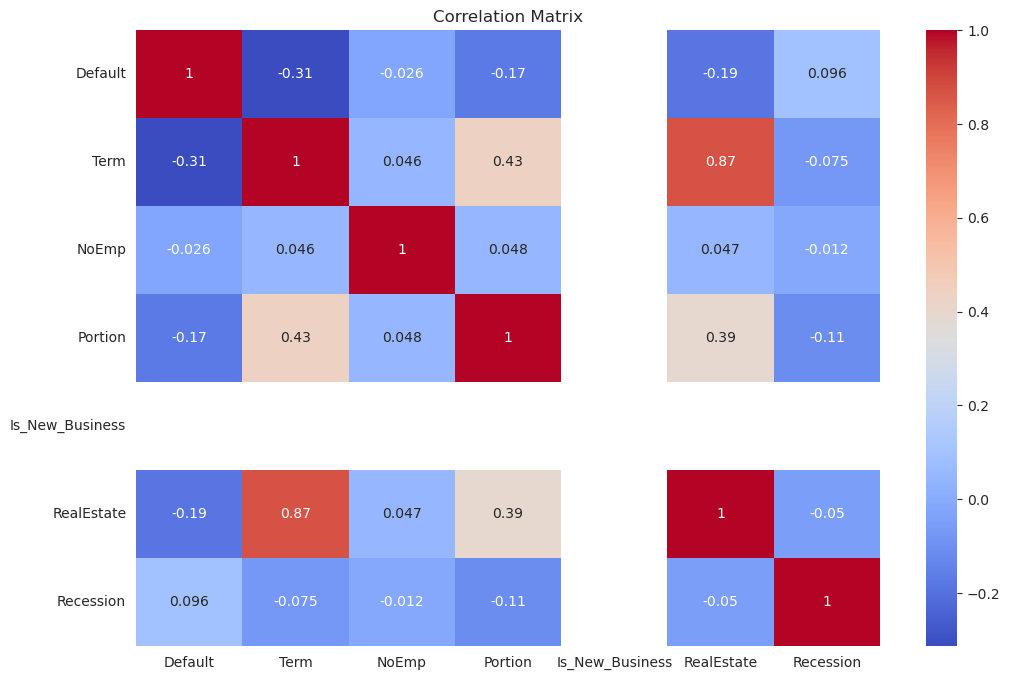

In [ ]:
# Selecting numerical variables for correlation analysis
correlation_data = data[['Default', 'Term', 'NoEmp', 'DisbursementGross', 'Portion', 'Is_New_Business', 'RealEstate', 'Recession']]

# Calculating the correlation matrix
correlation_matrix = correlation_data.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

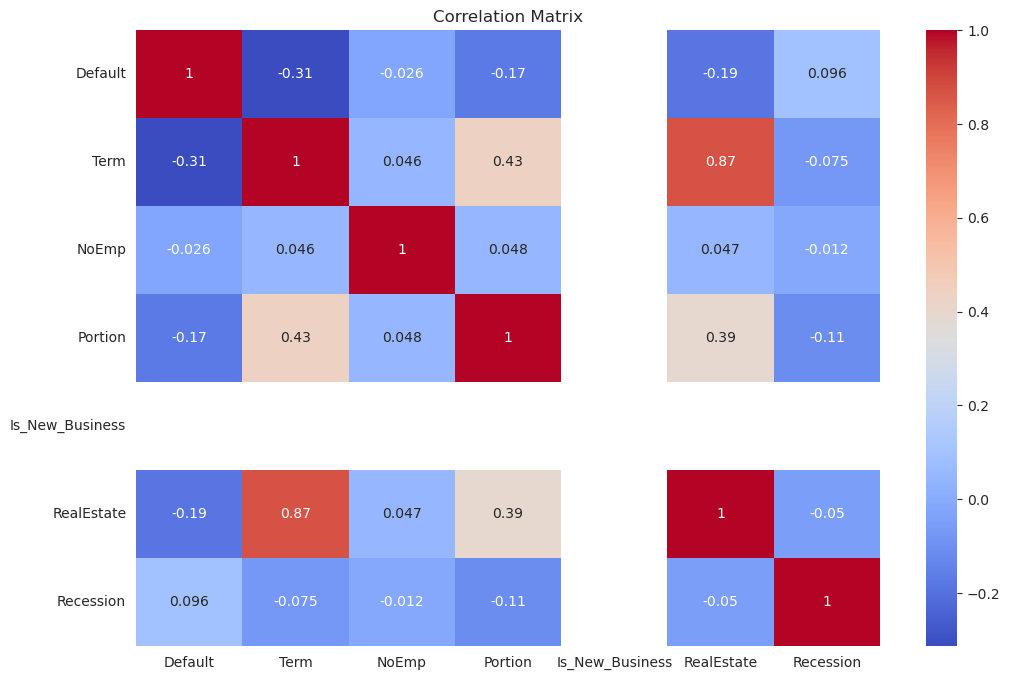

In [ ]:
# Selecting numerical variables for correlation analysis
correlation_data = data[['Default', 'Term', 'NoEmp', 'DisbursementGross', 'Portion', 'Is_New_Business', 'RealEstate', 'Recession']]

# Calculating the correlation matrix
correlation_matrix = correlation_data.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Displaying the first few rows of the dataset to verify the current state
data.head()

In [ ]:
# Converting 'SBA_Appv' and 'GrAppv' to numerical values
data['SBA_Appv'] = data['SBA_Appv'].replace('[\$,]', '', regex=True).astype(float)
data['GrAppv'] = data['GrAppv'].replace('[\$,]', '', regex=True).astype(float)

# Creating a feature to categorize businesses as new or established
data['Is_New_Business'] = data['NewExist'].apply(lambda x: 1 if x <= 2 else 0)

# Creating a feature to identify loans backed by real estate
data['RealEstate'] = data['Term'].apply(lambda x: 1 if x >= 240 else 0)

# Creating a feature to identify loans active during the Great Recession (December 2007 to June 2009)
start_recession = datetime.strptime('2007-12-01', '%Y-%m-%d')
end_recession = datetime.strptime('2009-06-30', '%Y-%m-%d')
data['Recession'] = data['DisbursementDate'].apply(lambda x: 1 if (x >= start_recession) & (x <= end_recession) else 0)

# Calculating the portion of the loan guaranteed by SBA
data['Portion'] = data['SBA_Appv'] / data['GrAppv']

# Creating a 'Default' column based on 'MIS_Status'
data['Default'] = data['MIS_Status'].apply(lambda x: 1 if x == 'CHGOFF' else 0)

# Check the first few rows to see the new features
data[['Is_New_Business', 'RealEstate', 'Recession', 'Portion', 'Default']].head()

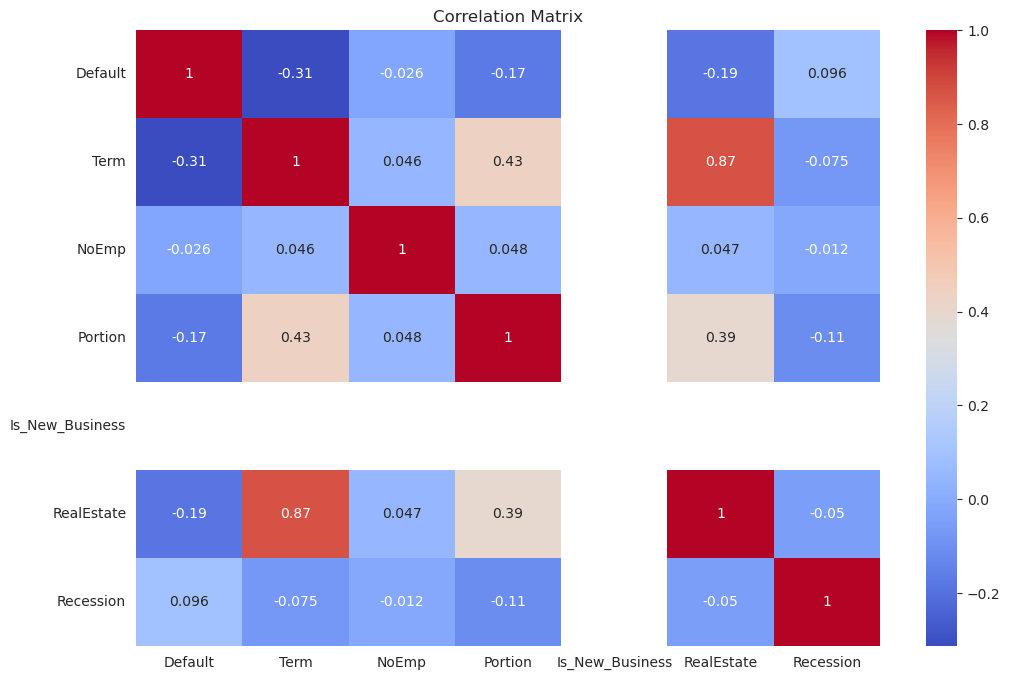

In [ ]:
# Selecting numerical variables for correlation analysis
correlation_data = data[['Default', 'Term', 'NoEmp', 'DisbursementGross', 'Portion', 'Is_New_Business', 'RealEstate', 'Recession']]

# Calculating the correlation matrix
correlation_matrix = correlation_data.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

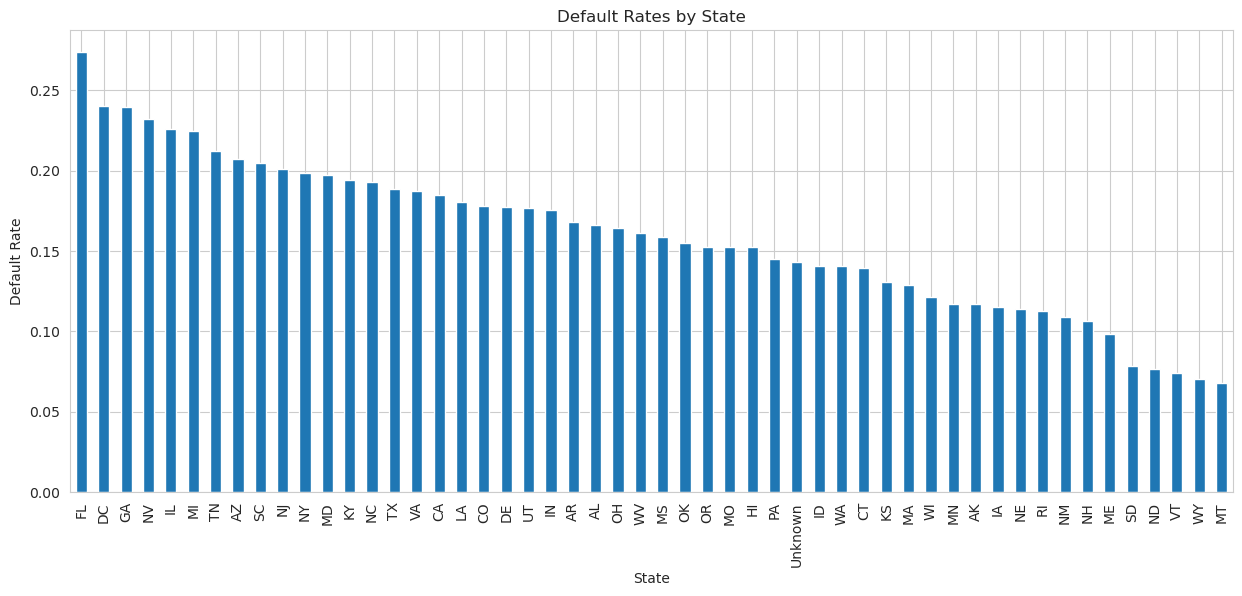

In [ ]:
# Calculating default rates by state
state_default_rates = data.groupby('State')['Default'].mean().sort_values(ascending=False)

# Plotting default rates by state
plt.figure(figsize=(15, 6))
state_default_rates.plot(kind='bar')
plt.title('Default Rates by State')
plt.ylabel('Default Rate')
plt.xlabel('State')
plt.xticks(rotation=90)
plt.show()

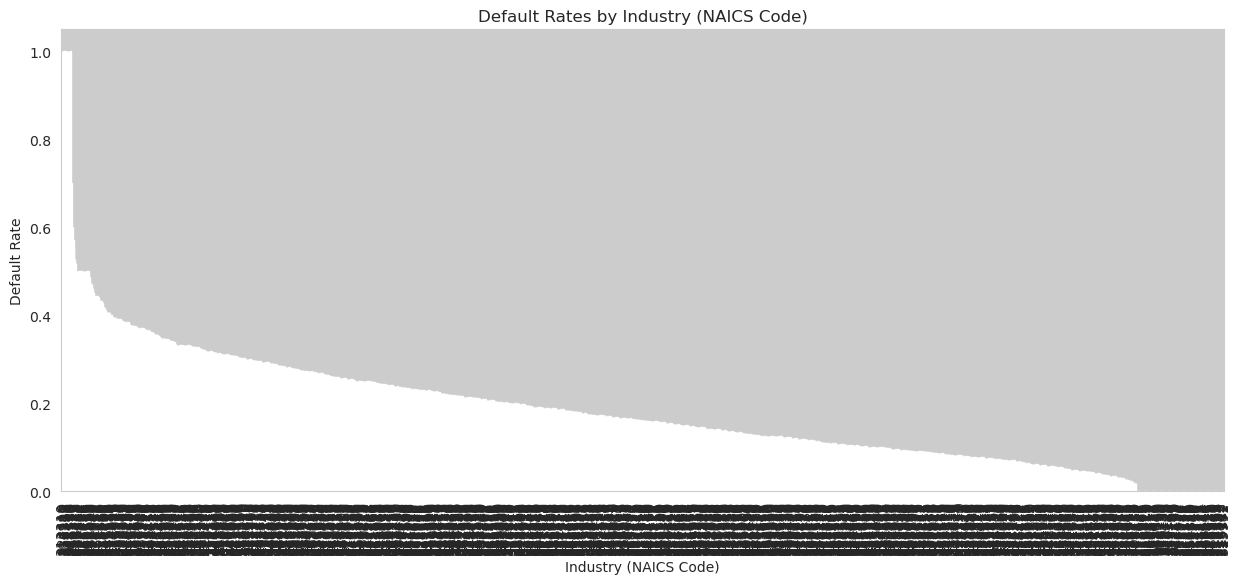

In [ ]:
# Calculating default rates by industry
industry_default_rates = data.groupby('NAICS')['Default'].mean().sort_values(ascending=False)

# Plotting default rates by industry
plt.figure(figsize=(15, 6))
industry_default_rates.plot(kind='bar')
plt.title('Default Rates by Industry (NAICS Code)')
plt.ylabel('Default Rate')
plt.xlabel('Industry (NAICS Code)')
plt.xticks(rotation=90)
plt.show()

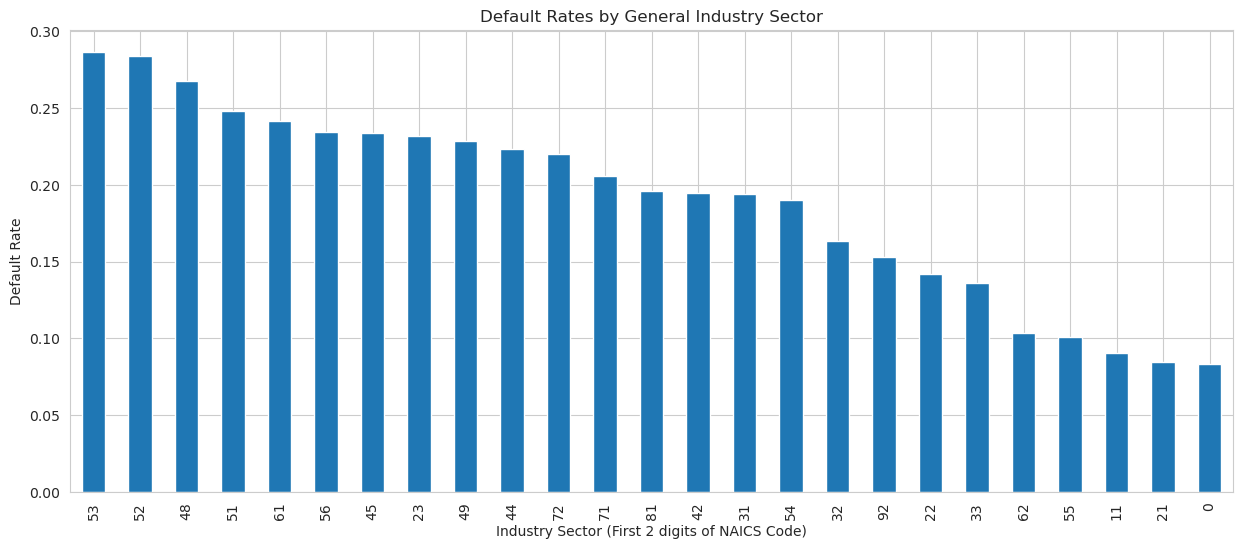

In [ ]:
# Extracting the first two digits of the NAICS code to represent the general industry sector
data['Industry_Sector'] = data['NAICS'].apply(lambda x: str(x)[:2])

# Calculating default rates by general industry sector
industry_sector_default_rates = data.groupby('Industry_Sector')['Default'].mean().sort_values(ascending=False)

# Plotting default rates by general industry sector
plt.figure(figsize=(15, 6))
industry_sector_default_rates.plot(kind='bar')
plt.title('Default Rates by General Industry Sector')
plt.ylabel('Default Rate')
plt.xlabel('Industry Sector (First 2 digits of NAICS Code)')
plt.xticks(rotation=90)
plt.show()

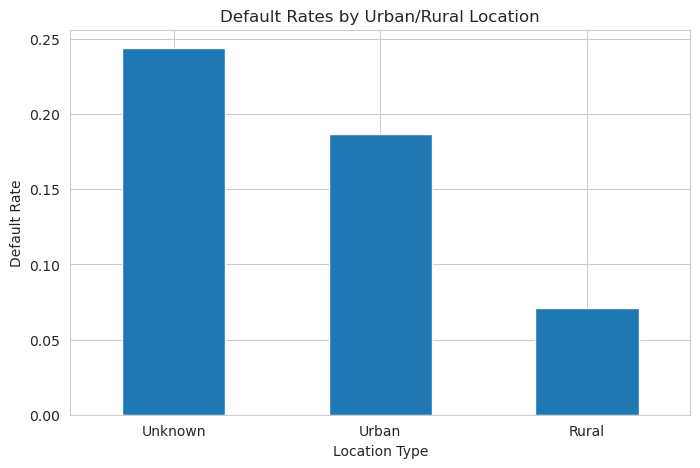

In [ ]:
# Calculating default rates by urban/rural location
urban_rural_default_rates = data.groupby('UrbanRural')['Default'].mean().sort_values(ascending=False)
urban_rural_default_rates.index = ['Unknown', 'Urban', 'Rural']

# Plotting default rates by urban/rural location
plt.figure(figsize=(8, 5))
urban_rural_default_rates.plot(kind='bar')
plt.title('Default Rates by Urban/Rural Location')
plt.ylabel('Default Rate')
plt.xlabel('Location Type')
plt.xticks(rotation=0)
plt.show()

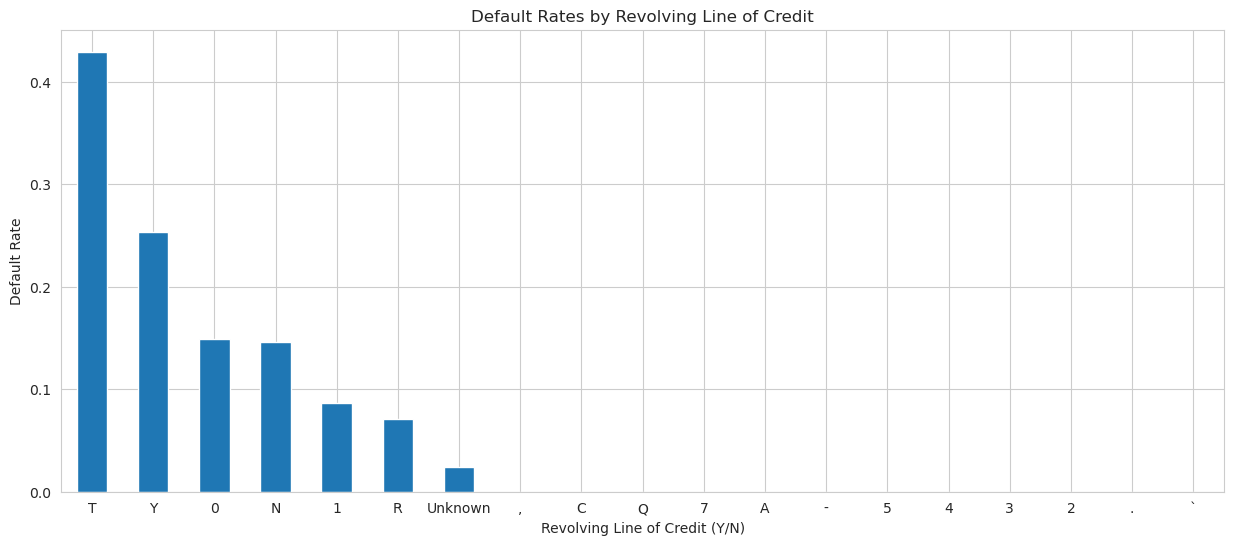

In [ ]:
# Calculating default rates by revolving line of credit
revline_default_rates = data.groupby('RevLineCr')['Default'].mean().sort_values(ascending=False)

# Plotting default rates by revolving line of credit
plt.figure(figsize=(15, 6))
revline_default_rates.plot(kind='bar')
plt.title('Default Rates by Revolving Line of Credit')
plt.ylabel('Default Rate')
plt.xlabel('Revolving Line of Credit (Y/N)')
plt.xticks(rotation=0)
plt.show()

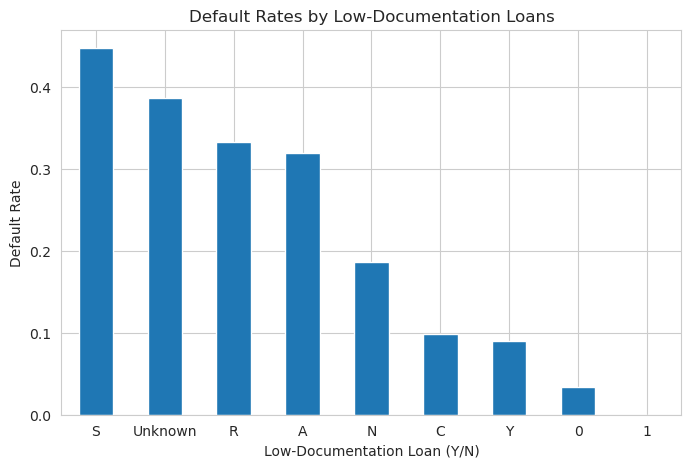

In [ ]:
# Calculating default rates by low-documentation loans
lowdoc_default_rates = data.groupby('LowDoc')['Default'].mean().sort_values(ascending=False)

# Plotting default rates by low-documentation loans
plt.figure(figsize=(8, 5))
lowdoc_default_rates.plot(kind='bar')
plt.title('Default Rates by Low-Documentation Loans')
plt.ylabel('Default Rate')
plt.xlabel('Low-Documentation Loan (Y/N)')
plt.xticks(rotation=0)
plt.show()

## Modeling Phase
Now that we have preprocessed the data and performed an extensive exploratory data analysis, we are ready to move on to the modeling phase. We will start by preparing the data for modeling, including splitting it into training and testing sets. Then, we will apply various machine learning models to predict loan default and evaluate their performance.

In [ ]:
# Defining the features (X) and target (y) variables
X = data.drop(columns=['Default'])
y = data['Default']

# Splitting the data into training and testing sets (80% training, 20% testing)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the shape of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((719331, 33), (179833, 33), (719331,), (179833,))

In [ ]:
# Selecting relevant features for modeling
features = ['Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'UrbanRural', 'DisbursementGross',
            'Is_New_Business', 'RealEstate', 'Recession', 'Portion']
X = data[features]
y = data['Default']

# Splitting the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the shape of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((719331, 11), (179833, 11), (719331,), (179833,))

In [ ]:
# Converting 'DisbursementGross' column to numerical by removing the currency symbol and commas
data['DisbursementGross'] = data['DisbursementGross'].replace('[\$,]', '', regex=True).astype(float)

# Selecting relevant features for modeling again
X = data[features]
y = data['Default']

# Splitting the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the data types of the features
X_train.dtypes

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Creating a logistic regression model
logistic_model = LogisticRegression(random_state=42)

# Fitting the model to the training data
logistic_model.fit(X_train, y_train)

# Predicting the target variable on the test data
y_pred = logistic_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

accuracy, classification_rep, confusion_mat

(0.8248263666846463,
 '              precision    recall  f1-score   support\n\n           0       0.83      1.00      0.90    148458\n           1       0.45      0.02      0.03     31375\n\n    accuracy                           0.82    179833\n   macro avg       0.64      0.51      0.47    179833\nweighted avg       0.76      0.82      0.75    179833\n',
 array([[147783,    675],
        [ 30827,    548]]))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Creating a Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

# Fitting the model to the training data
random_forest_model.fit(X_train, y_train)

# Predicting the target variable on the test data
y_pred_rf = random_forest_model.predict(X_test)

# Evaluating the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)
confusion_mat_rf = confusion_matrix(y_test, y_pred_rf)

accuracy_rf, classification_rep_rf, confusion_mat_rf

(0.9260146914081397,
 '              precision    recall  f1-score   support\n\n           0       0.95      0.96      0.96    148458\n           1       0.81      0.75      0.78     31375\n\n    accuracy                           0.93    179833\n   macro avg       0.88      0.86      0.87    179833\nweighted avg       0.92      0.93      0.92    179833\n',
 array([[143082,   5376],
        [  7929,  23446]]))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Creating a Gradient Boosting model
gradient_boosting_model = GradientBoostingClassifier(random_state=42)

# Fitting the model to the training data
gradient_boosting_model.fit(X_train, y_train)

# Predicting the target variable on the test data
y_pred_gb = gradient_boosting_model.predict(X_test)

# Evaluating the model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
classification_rep_gb = classification_report(y_test, y_pred_gb)
confusion_mat_gb = confusion_matrix(y_test, y_pred_gb)

accuracy_gb, classification_rep_gb, confusion_mat_gb

(0.925580955664422,
 '              precision    recall  f1-score   support\n\n           0       0.94      0.97      0.96    148458\n           1       0.84      0.71      0.77     31375\n\n    accuracy                           0.93    179833\n   macro avg       0.89      0.84      0.86    179833\nweighted avg       0.92      0.93      0.92    179833\n',
 array([[144063,   4395],
        [  8988,  22387]]))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Creating a K-Nearest Neighbors model
knn_model = KNeighborsClassifier()

# Fitting the model to the training data
knn_model.fit(X_train, y_train)

# Predicting the target variable on the test data
y_pred_knn = knn_model.predict(X_test)

# Evaluating the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
classification_rep_knn = classification_report(y_test, y_pred_knn)
confusion_mat_knn = confusion_matrix(y_test, y_pred_knn)

accuracy_knn, classification_rep_knn, confusion_mat_knn

(0.8832527956492968,
 '              precision    recall  f1-score   support\n\n           0       0.91      0.95      0.93    148458\n           1       0.71      0.56      0.63     31375\n\n    accuracy                           0.88    179833\n   macro avg       0.81      0.76      0.78    179833\nweighted avg       0.88      0.88      0.88    179833\n',
 array([[141234,   7224],
        [ 13771,  17604]]))

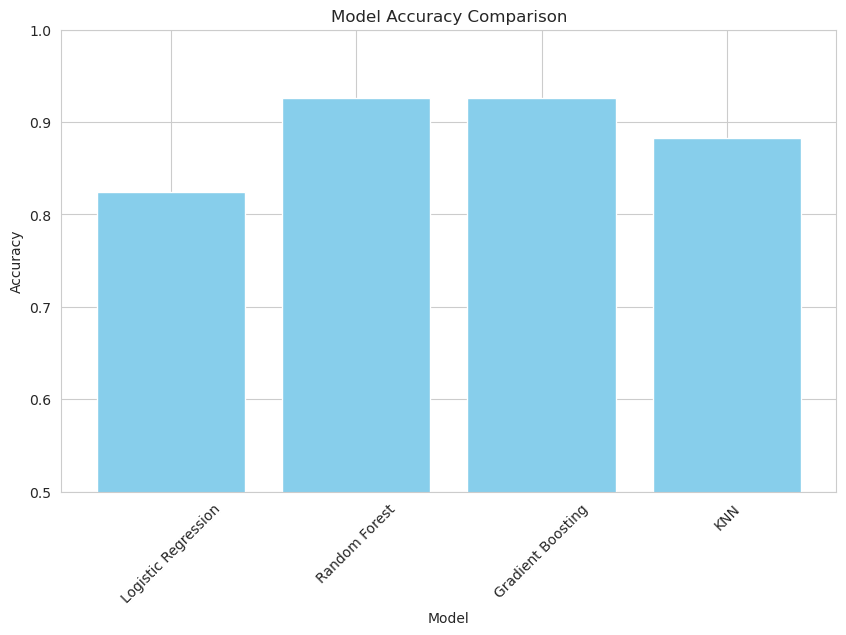

In [ ]:
import matplotlib.pyplot as plt

# Creating a dictionary to store the accuracy of each model
model_accuracies = {
    'Logistic Regression': accuracy,
    'Random Forest': accuracy_rf,
    'Gradient Boosting': accuracy_gb,
    'KNN': accuracy_knn
}

# Converting the dictionary to a DataFrame for better visualization
accuracy_df = pd.DataFrame(list(model_accuracies.items()), columns=['Model', 'Accuracy'])

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.bar(accuracy_df['Model'], accuracy_df['Accuracy'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0.5, 1)
plt.show()

# Displaying the accuracy DataFrame
accuracy_df

In [ ]:
!pip install shap
import shap

# Create a SHAP explainer object with the Random Forest model
explainer_rf = shap.Explainer(random_forest_model)



# Calculate SHAP values for the test data
shap_values_rf = explainer_rf(X_test)


# Plot the summary plot for SHAP values
shap.summary_plot(shap_values_rf, X_test)


Warning The connection to your kernel was interrupted. This could have happened because: 
 
 Your kernel ran out of memory. 
 You attempted to output more than 100MB of data. 
 Your kernel experienced an unexpected shutdown.